# Working with data

_There is a helper function in scikit-learn to load files stores in a folder structure similar to the one below, where each subfolder corresponds to a label._

<img src="../img/load_files_example.png">

In [81]:
from sklearn.datasets import load_files
import numpy as np

reviews_train = load_files("../data/aclImdb/train/")

# load_files returns a bunch, containing training texts and training labels
# here I reduced the size of training elements to be able to run in my computer
text_train, y_train = reviews_train.data, reviews_train.target


print(len(text_train))
print(len(y_train))


print(f"Type of text_train: {type(text_train)}")
print(f"Lenght of text_train: {len(text_train)}")
print(f"FIRST ENTRY \n\n {text_train[0]}")





25000
25000
Type of text_train: <class 'list'>
Lenght of text_train: 25000
FIRST ENTRY 

 b"Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty."


We can see that the entry has some html markup. It is usually better to clean it up before proceeding with the project.

In [82]:
text_train = [doc.replace(b"<br />", b" ") for doc in text_train]

# check the number of samples per label
print(f"Samples per class (training): {np.bincount(y_train)}")
print(np.unique(y_train))
print(y_train[::500])

# loading the test set using the same approach as the one above

reviews_test = load_files("../data/aclImdb/test/")
text_test, y_test = reviews_test.data, reviews_test.target

print(f"Number of documents in test data: {len(text_test)}")
print(f"Samples per class (Test): {np.bincount(y_test)} ")

text_test = [doc.replace(b"<br />", b" ") for doc in text_test]

Samples per class (training): [12500 12500]
[0 1]
[1 1 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0 1 0
 1 1 1 1 0 0 0 1 0 0 0 1 1]
Number of documents in test data: 25000
Samples per class (Test): [12500 12500] 


## 7.1 Representing text as a Bag of Words

To do so, you mostly discart owrds that are not meaninful, such as stop-words. You basically count how many times each word appears in the document. Computing the bag of words consists of three steps:

**01 / Tokenization**: Split each word by a delimitator, such as space and punctuation. Each word becomes now a *token*.

**02 / Vocabulary building**: Collect all words that appear in any document, and then organise them (let's say, by alphabetic order)

**03 / Enconding:** For each document, count how often a give word appears in the document.

The bag-of-words representation is implemented in *CountVectorizer*, which is a transformer


**REMEMBER YOU NEED TO TRANSFORM BOTH THE TRAIN AND TEST BEFORE DOING ANYTHING**

In [83]:
from sklearn.feature_extraction.text import CountVectorizer


vect = CountVectorizer().fit(text_train) #fits the vocabulary
X_train = vect.transform(text_train) # transforms the data (encoding)

print(f"Vocabulary size: {len(vect.vocabulary_)}")

print(f"X_train: \n {repr(X_train)}") # shows a representation of the sparse array used to store the data


Vocabulary size: 74849
X_train: 
 <25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3431196 stored elements in Compressed Sparse Row format>


In [84]:
# another way to get more details about the vocabulary
feature_names = vect.get_feature_names_out()

print(f"Number of features {len(feature_names)}")
print(f"First 20 features \n {feature_names[:20]}")
print(f"Features 150 to 200 \n {feature_names[150:200]}")
print(f"Every 2000th feature {feature_names[::2000]}")

Number of features 74849
First 20 features 
 ['00' '000' '0000000000001' '00001' '00015' '000s' '001' '003830' '006'
 '007' '0079' '0080' '0083' '0093638' '00am' '00pm' '00s' '01' '01pm' '02']
Features 150 to 200 
 ['14ieme' '14s' '14th' '14yr' '14ème' '15' '150' '1500' '1500s'
 '150_worst_cases_of_nepotism' '150k' '150m' '151' '152' '153' '1547'
 '155' '156' '1561' '157' '158' '1594' '15mins' '15minutes' '15s' '15th'
 '16' '160' '1600' '1600s' '160lbs' '161' '1610' '163' '164' '165' '166'
 '1660s' '168' '169' '1692' '16ieme' '16k' '16mm' '16s' '16th' '16x9'
 '16ème' '16éme' '17']
Every 2000th feature ['00' 'aesir' 'aquarian' 'barking' 'blustering' 'bête' 'chicanery'
 'condensing' 'cunning' 'detox' 'draper' 'enshrined' 'favorit' 'freezer'
 'goldman' 'hasan' 'huitieme' 'intelligible' 'kantrowitz' 'lawful' 'maars'
 'megalunged' 'mostey' 'norrland' 'padilla' 'pincher' 'promisingly'
 'receptionist' 'rivals' 'schnaas' 'shunning' 'sparse' 'subset'
 'temptations' 'treatises' 'unproven' 'walkm

In [85]:
# First simple model

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

scores = cross_val_score(LogisticRegression(max_iter=1500000), X_train, y_train, cv=5)
print(f"Mean cross-validation accuracy {np.mean(scores)}")

Mean cross-validation accuracy 0.88128


In [86]:
# Tunning the model with cv

from sklearn.model_selection import GridSearchCV
parameter_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(LogisticRegression(max_iter=1500000), param_grid=parameter_grid, cv=5) 
#note here that the best would be using a pipeline, this is for simplicity
# however as the CountVectoriser does not collect statistics the results are valid still
grid.fit(X_train, y_train)
print(f"Best cross-validation score: {grid.best_score_}")
print(f"Best parameters: {grid.best_params_}")

Best cross-validation score: 0.8881599999999998
Best parameters: {'C': 0.1}


In [87]:
# Now that we have the parameters, we can evaluate the generalisation of the model on the test set

# remember, we start by transforming the data
X_test = vect.transform(text_test)

print(X_test.shape)
print(f"{grid.score(X_test, y_test):.5f}")

(25000, 74849)
0.87888


The performance of the model is very poor. We can try to improve it by only using tokes that appear in at least 2 documents (or 3, or 5, it doesn't matter.) If the token only appears once, the chances are that it doesn't appear in the test set. We do so my setting the parameter min_df in the CountVectorizer.

In [88]:
vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
print(f"X_train with mind_df=5: {repr(X_train)}")

# PS You can also use max_df to eliminate words that appear in many documents

X_train with mind_df=5: <25000x27271 sparse matrix of type '<class 'numpy.int64'>'
	with 3354014 stored elements in Compressed Sparse Row format>


In [89]:
# doing a new grid search with the new  model, less features

parameter_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(LogisticRegression(max_iter=1500000), param_grid=parameter_grid, cv=5) 
#note here that the best would be using a pipeline, this is for simplicity
# however as the CountVectoriser does not collect statistics the results are valid still
grid.fit(X_train, y_train)
print(f"Best cross-validation score: {grid.best_score_:.2f}")
print(f"Best parameters: {grid.best_params_}")


# Evaluate the model
X_test = vect.transform(text_test)

print(X_test.shape)
print(f"{grid.score(X_test, y_test):.2f}")

Best cross-validation score: 0.89
Best parameters: {'C': 0.1}
(25000, 27271)
0.88


## 7.2 Stopwords

Another way to get rid of uninformative words is by discarting words that are too frequent to be informative. You can follow one of the approaches:
- Use a dictionary of stopwords. In sciki-learn you have feature_extraction.text
- Discarting words that appear too frequently

For the first approach:

In [92]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print(f"Number of stop words {len(ENGLISH_STOP_WORDS)}")
print(f"Every 10th stopword {list(ENGLISH_STOP_WORDS)[::10]}")


# Specifying stop_words="english" uses the built-in list.
# We could also augment it and pass our own.
vect = CountVectorizer(min_df=5, stop_words="english").fit(text_train)
# Here I also eliminate words that appear in more than 100 documents, but setting max_df=100
X_train = vect.transform(text_train)
print("X_train with stop words:\n{}".format(repr(X_train)))


Number of stop words 318
Every 10th stopword ['amoungst', 'might', 'out', 'take', 'elsewhere', 'other', 'co', 'has', 'again', 'which', 'every', 'thick', 'per', 'an', 'full', 'very', 'find', 'our', 'anywhere', 'my', 'many', 'them', 'eg', 'eight', 'seeming', 'had', 'were', 'here', 'herein', 'without', 'show', 'wherein']
X_train with stop words:
<25000x26966 sparse matrix of type '<class 'numpy.int64'>'
	with 2149958 stored elements in Compressed Sparse Row format>


In [93]:
grid = GridSearchCV(LogisticRegression(max_iter=1500000), parameter_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))


# Evaluate the model
X_test = vect.transform(text_test)

print(X_test.shape)
print(f"{grid.score(X_test, y_test):.2f}")

Best cross-validation score: 0.88
(25000, 26966)
0.87


## 7.3 Rescaling the data with td-idf

You can remove features that are deemed unimporant. One common way to do so is by using _term frequency-inverse document frequency (tf-idf)_. The idea is to give more weigh to any terms that appear often in one document, but not in other documents in the corpus, as that term is likely to be very descriptive of the document in question.

We need to use the pipeline for this implementation as the algorithm uses statistical properties of the data.

In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline



pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None), LogisticRegression(max_iter=15000000))

parameter_grid = {"logisticregression__C":[0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(pipe, param_grid=parameter_grid, cv=5)
grid.fit(text_train, y_train)

print(f"Best cross-validation score: {grid.best_score_}")
print(f"Best parameters: {grid.best_params_}")

print(grid.score(text_test, y_test))

Best cross-validation score: 0.8938400000000002
Best parameters: {'logisticregression__C': 0.001}
0.88508


We can go further and find the words with higher and smaller tf-idf scores:

In [106]:
vectoriser = grid.best_estimator_.named_steps["tfidfvectorizer"]

# transform the training dataset
X_train = vectoriser.transform(text_train)

# find maximum value for each of the features over the dataset
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()

# get feature names
feature_names = np.array(vectoriser.get_feature_names_out())

print(f"Features with lowest tf-idf: {feature_names[sorted_by_tfidf[:20]]}")
print(f"Features with highest td-idf: {feature_names[sorted_by_tfidf[-20:]]}")

Features with lowest tf-idf: ['poignant' 'disagree' 'instantly' 'importantly' 'lacked' 'occurred'
 'currently' 'altogether' 'nearby' 'undoubtedly' 'directs' 'fond'
 'stinker' 'avoided' 'emphasis' 'commented' 'disappoint' 'realizing'
 'downhill' 'inane']
Features with highest td-idf: ['coop' 'homer' 'dillinger' 'hackenstein' 'gadget' 'taker' 'macarthur'
 'vargas' 'jesse' 'basket' 'dominick' 'the' 'victor' 'bridget' 'victoria'
 'khouri' 'zizek' 'rob' 'timon' 'titanic']


In [107]:
# these are the words that appear in several documents, and therefore, are deemed as less important
sorted_by_idf = np.argsort(vectorizer.idf_) 
print("Features with lowest idf:\n{}".format(
feature_names[sorted_by_idf[:100]]))

Features with lowest idf:
['the' 'and' 'of' 'to' 'this' 'is' 'it' 'in' 'that' 'but' 'for' 'with'
 'was' 'as' 'on' 'movie' 'not' 'have' 'one' 'be' 'film' 'are' 'you' 'all'
 'at' 'an' 'by' 'so' 'from' 'like' 'who' 'they' 'there' 'if' 'his' 'out'
 'just' 'about' 'he' 'or' 'has' 'what' 'some' 'good' 'can' 'more' 'when'
 'time' 'up' 'very' 'even' 'only' 'no' 'would' 'my' 'see' 'really' 'story'
 'which' 'well' 'had' 'me' 'than' 'much' 'their' 'get' 'were' 'other'
 'been' 'do' 'most' 'don' 'her' 'also' 'into' 'first' 'made' 'how' 'great'
 'because' 'will' 'people' 'make' 'way' 'could' 'we' 'bad' 'after' 'any'
 'too' 'then' 'them' 'she' 'watch' 'think' 'acting' 'movies' 'seen' 'its'
 'him']


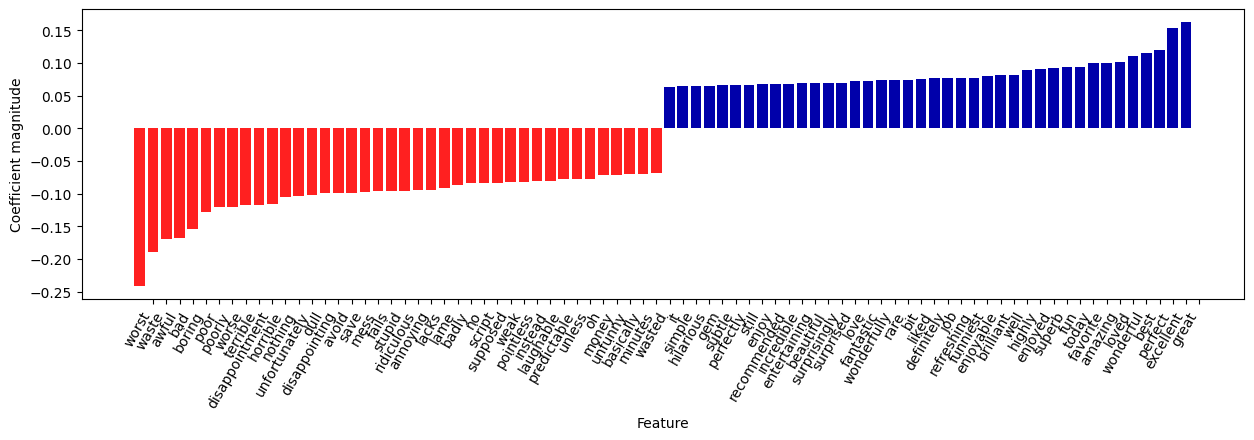

In [108]:
# Further, if we look at the top coefficients, we can see the words that are deemed important for the model to classify a review

import mglearn
mglearn.tools.visualize_coefficients(
grid.best_estimator_.named_steps["logisticregression"].coef_,
feature_names, n_top_features=40)

## 7.4 Bag-of-words with more than one word (n-gram)

If we consider the word representation but do not consider their order, the sentences  _"it's bad, not good at all"_ and _"it's good, not bad at all"_, have the same representation. To solve this issue we can consider tokens of more than 1 word. We can use the paramter **ngram_range** of CountVectorizer or TfidfVectorizer. This parameter is a tupple, considering the minimum and maximum lenght of senquences of tokens. Using longer sequences creates a lot of new features, and it can be overfitting (5 is already quite long, for example)



In [112]:
# let's use a grid search to find the best number of n-grams for the movie dataset

pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression(max_iter=15000000))

# running the grid search takes a long time because of the relatively large grid and the inclusion of trigrams

parameter_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100],
"tfidfvectorizer__ngram_range": [(1,1), (1,2), (1, 3)]}

grid = GridSearchCV(pipe, param_grid=parameter_grid, cv=5)
grid.fit(text_train, y_train)

print(f"Best cross-validation score: {grid.best_score_}")
print(f"Best parameters:\n {grid.best_params_}")

Best cross-validation score: 0.9064400000000001
Best parameters:
 {'logisticregression__C': 100, 'tfidfvectorizer__ngram_range': (1, 3)}


## 7.5 Advanced Tokenisation, Stemming and Lemmatisation

In the examples above, we treat words like "replace", "replaced", "replacing" as different words, although they do not produce necessarily different values in the "real meaning" of a sentence, and it can lead to overfitting. To solve this issue there are two normalisation approaches:

- Stemming: Considers the stem of the word; Drops suffix. The Potter stemmer is widely use, imported from the nltk package

- Lemmatisation: It's a dictionary of known word forms that has been explicitly verified by a human. Here the word "worst" can "become" bad. / in the example below we will use the spacy package

Spelling correction is also a normalisation approach (if needed, look more into it, not covered in this book)